In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Projects/bind_RBM`
Precompiling packages...
   7246.3 ms  ✓ bind_RBM
  1 dependency successfully precompiled in 9 seconds. 548 already precompiled.


In [9]:
using CairoMakie
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v, mean_from_inputs
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
             sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
split_idx = 81
using JLD2
using MultivariateStats
using MLJ, MLJLinearModels
using Random: MersenneTwister, shuffle, bitrand
using DataFrames
using Logging
using SequenceLogos
using XLSX
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
using bind_RBM: plot_model_vs_data, create_binding_dictionary_Gogl, create_binding_dictionary, score_strings, parse_rules_file

In [3]:
data_Gogl = create_binding_dictionary_Gogl("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022.xlsx", "/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/PDZ_2022_final.xlsx", 4)
data_Stiffler = create_binding_dictionary("/home/jboccato/Projects/bind_RBM/artifacts/data/labelled/output.txt")


Skipped rows: 2037


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 84 entries:
  "----------GFGIAISGGRDNP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------SLGLSIAGGVGSP… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------PWGFRLQGGKDFN… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------FLGISIVGQSNER… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GFGLTVSG--DN-… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGLSIVGKRSGS… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-----KKDSEGFGFVLRGAKAQT… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGFSILDYQDPI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VKLFK-NSSGLGFSFSREDNLI… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "----------GLGF

In [4]:
function unique_elements_from_dict(d::Dict)
    uniq = Set{String}()
    for v in values(d)
        union!(uniq, v.elements)
    end
    return uniq
end

uniq_Gogl     = unique_elements_from_dict(data_Gogl)
uniq_Stiffler = unique_elements_from_dict(data_Stiffler)

common = intersect(uniq_Gogl, uniq_Stiffler)
n_common = length(common)

println("Unique elements in common: ", n_common)

function filter_dict_by_elements(d::Dict, common_elements::Set{String})
    out = Dict{eltype(keys(d)), eltype(values(d))}()

    for (k, v) in d
        filtered = [e for e in v.elements if e in common_elements]

        if !isempty(filtered)
            # reconstruct named tuple, replacing only `elements`
            out[k] = merge(v, (elements = filtered,))
        end
    end

    return out
end


filtered_Gogl     = filter_dict_by_elements(data_Gogl, common)
filtered_Stiffler = filter_dict_by_elements(data_Stiffler, common)

union_dict = merge(filtered_Gogl, filtered_Stiffler)
union_tot = merge(data_Gogl, data_Stiffler)

Unique elements in common: 53


Dict{String, @NamedTuple{elements::Vector{String}, labels::Vector{Int64}}} with 338 entries:
  "-------GPAPWGFRLQGGKDFN… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLEK-MSAGLGFSLEGGKGSL… => (elements = ["SKSLERATQL", "LLQEEWETVM", "THREVK…
  "-----------------------… => (elements = ["DTLEKFVEGL", "RRSQSRESQC", "SSRTRR…
  "-VELTK-NVQGLGITIAGYIGDK… => (elements = ["SSIDLWETAL", "STLTIFETAL", "DTLEKF…
  "-------DGGPLGIHVVPFSARG… => (elements = ["EPTTTTSVPL", "SSEGVPDLLV", "DTLEKF…
  "-----TVSGNGLGIRIVGGKEIP… => (elements = ["RSLEEEESQL", "EMDRRPATVV", "DPRNTQ…
  "-------KNPGLGFSISGGISGQ… => (elements = ["HYPASPDSWV", "QYPGSPDSWV", "PLPPEE…
  "-IELEK-GSKGLGFSILDYQDPI… => (elements = ["SVISRREWYV", "QKNKDREYYV", "GDSSRK…
  "----------GLGFSIAGGVGNQ… => (elements = ["NSLDKLKTDC", "VDFPPKESSL", "VDLLPK…
  "-VTLKRDPHRGFGFVINEGEYSG… => (elements = ["LHLHGTGIQV", "SVISRREWYV", "DSATVR…
  "-VVLTADPVTGFG

In [14]:
# Or flatten into a single vector of all elements
all_elements_flat = vcat([value.elements for value in values(union_dict)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_common = score_strings(file_content, all_elements_flat)


Dict{String, Vector{Float64}} with 53 entries:
  "RSSGGDDFWF" => [0.0, 0.2, 0.2, 0.666667, 0.75, 1.0, 0.166667, 0.4, 0.166667,…
  "DSEEELPTRL" => [0.0, 0.0, 0.2, 0.166667, 0.25, 0.25, 0.166667, 0.0, 0.5, 0.6…
  "PDSNPEESSV" => [0.4, 0.2, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.2,…
  "EFKQTSSFLV" => [0.2, 0.4, 0.4, 0.5, 0.75, 0.5, 0.333333, 0.0, 0.166667, 0.0,…
  "SRPRPDDLEI" => [0.0, 0.0, 0.4, 0.5, 0.5, 0.75, 0.166667, 0.0, 0.166667, 0.0,…
  "NKSEPFLTWL" => [0.0, 0.0, 0.2, 0.333333, 0.75, 0.5, 0.5, 0.6, 0.333333, 0.6,…
  "KPDKQEEFYA" => [0.0, 0.2, 0.2, 0.5, 0.5, 0.75, 0.0, 0.0, 0.166667, 0.2, 0.33…
  "RQKEVRESKC" => [0.6, 0.0, 0.0, 0.333333, 0.0, 0.25, 0.0, 0.0, 0.5, 0.4, 0.33…
  "KKNKDKEYYV" => [0.4, 0.2, 0.4, 0.666667, 0.75, 1.0, 0.166667, 0.0, 0.5, 0.2,…
  "ASGLDKRDYV" => [0.4, 0.2, 0.2, 0.5, 0.5, 0.5, 0.333333, 0.0, 0.333333, 0.0, …
  "AHGSTRDQSI" => [0.2, 0.0, 0.2, 0.333333, 0.25, 0.5, 0.166667, 0.0, 0.5, 0.0,…
  "DTKNYKQTSV" => [0.6, 0.2, 0.2, 0.333333, 0.25, 0.25, 0.1666

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


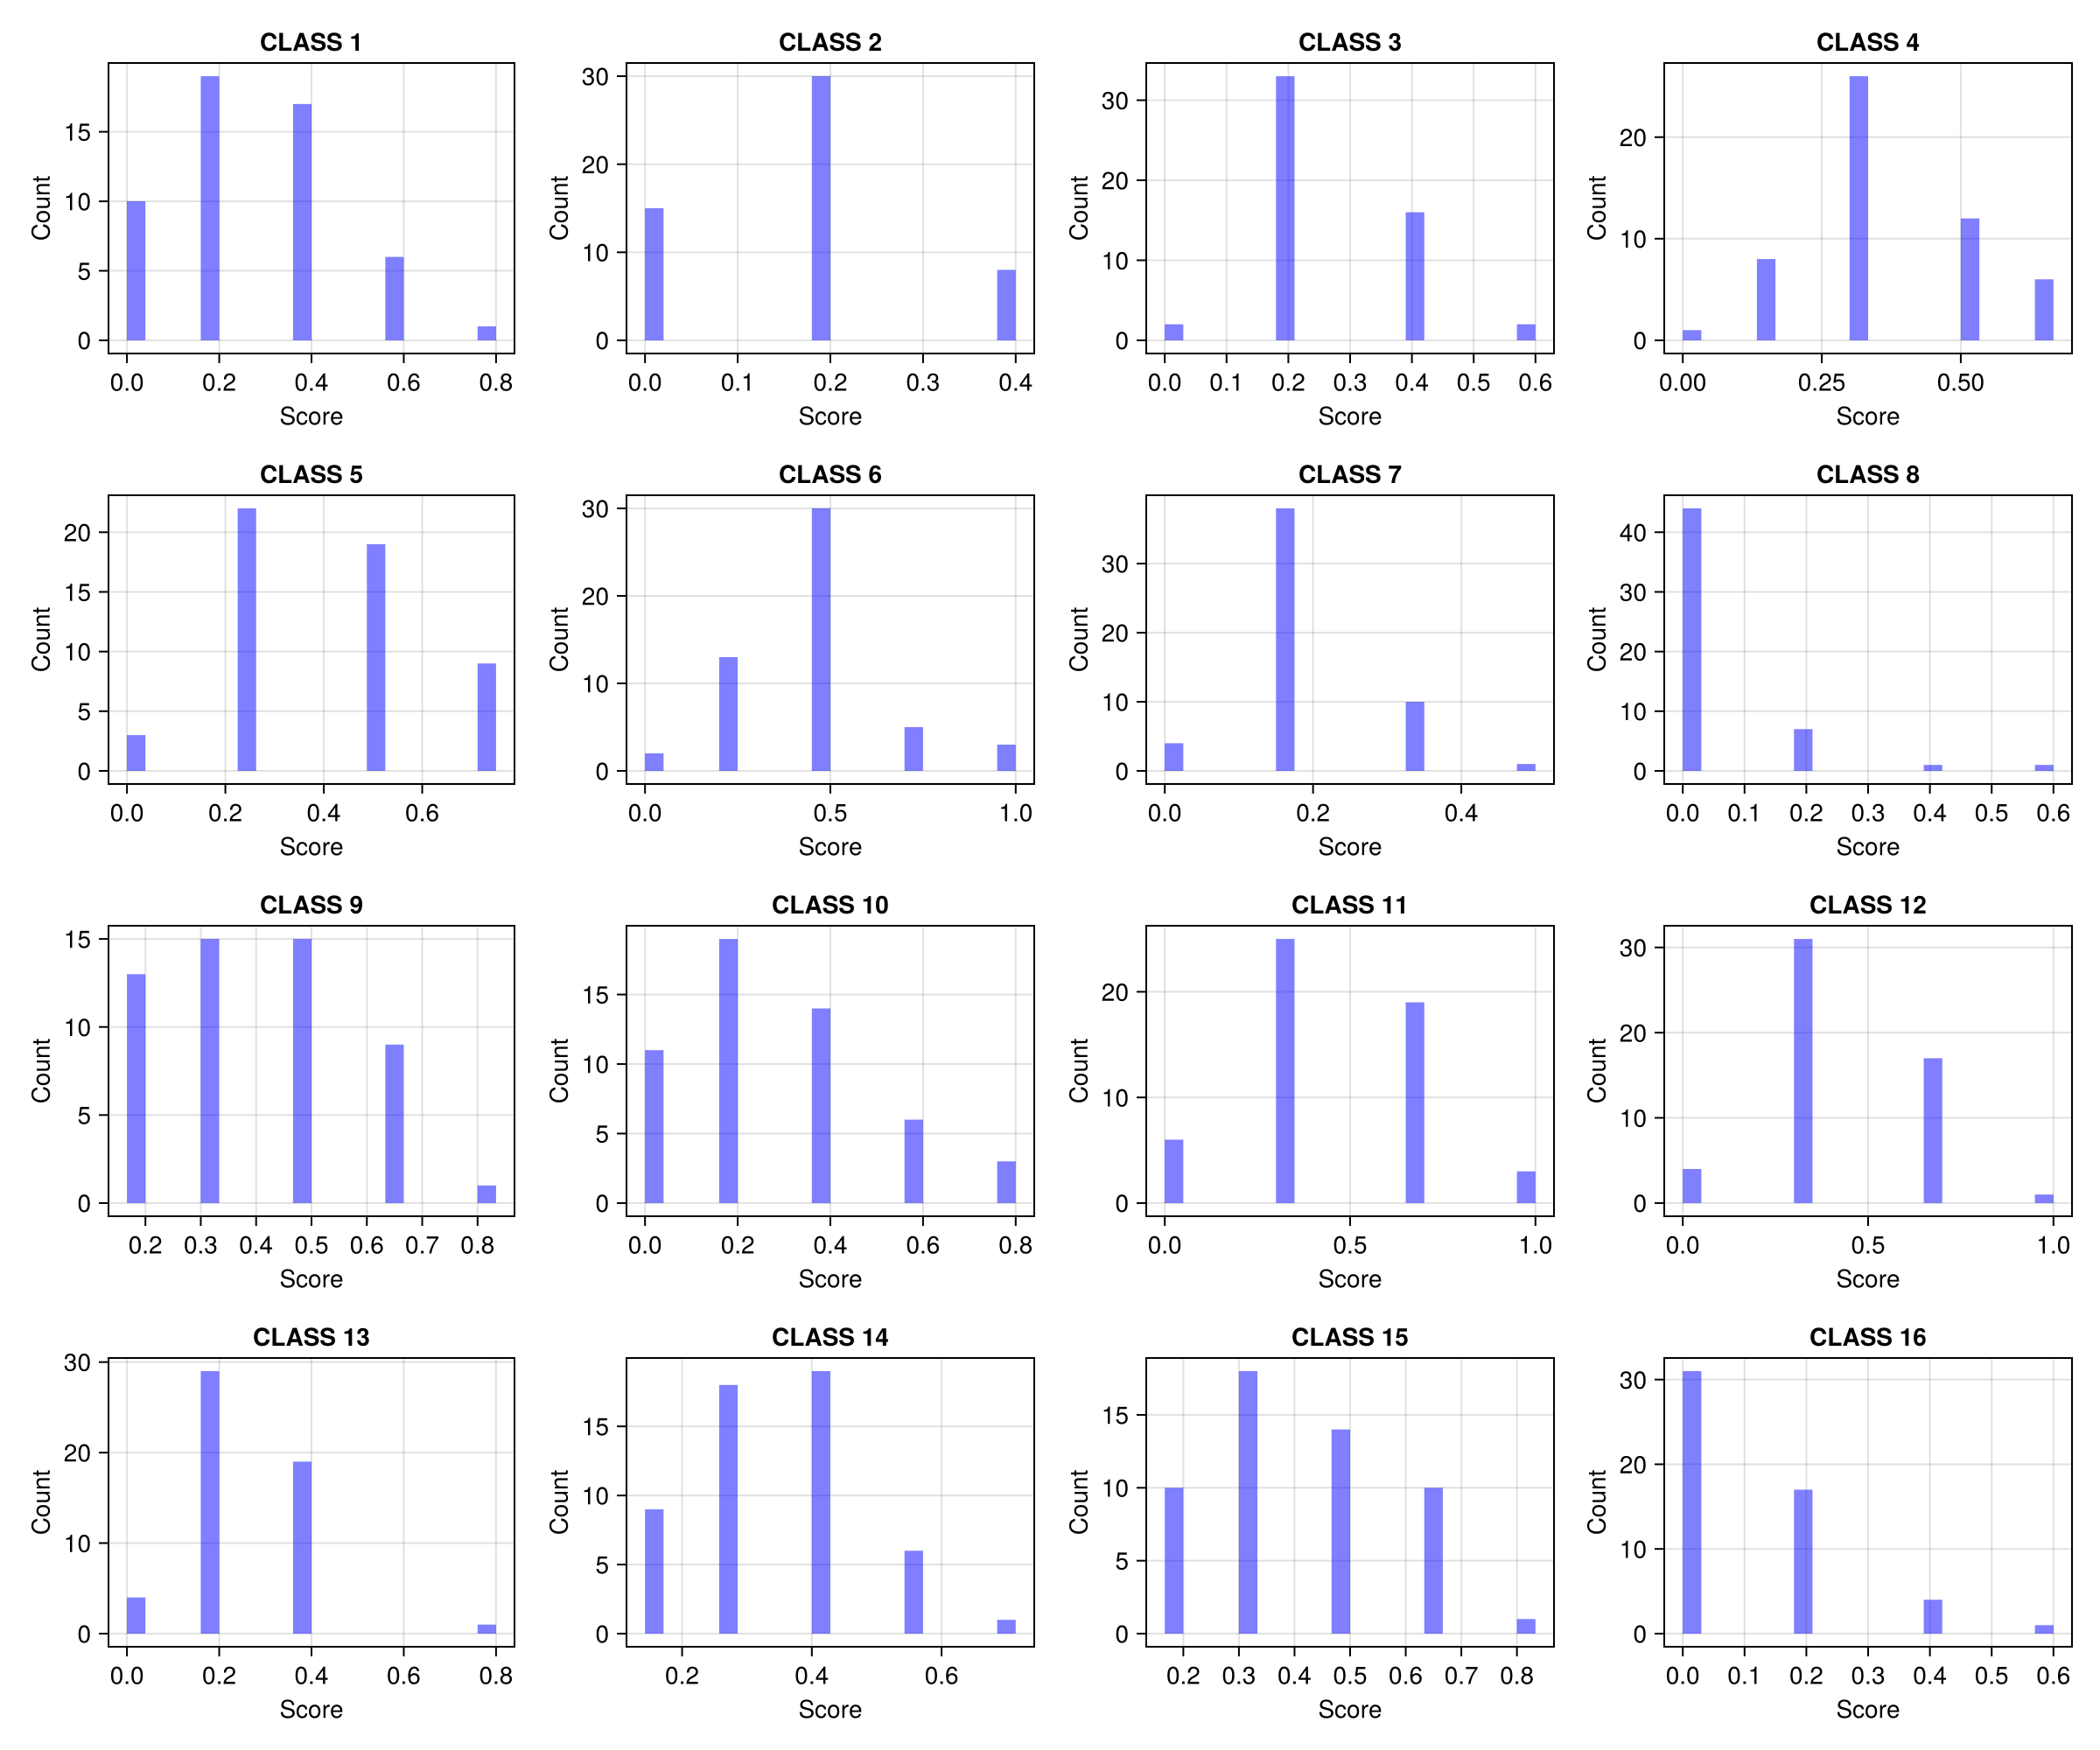

In [15]:
using CairoMakie

function plot_histograms(results)
    all_scores = collect(values(results))
    n_classes = length(all_scores[1])
    
    fig = Figure(resolution = (1200, 1000))
    
    for i in 1:n_classes
        row = div(i - 1, 4) + 1
        col = mod(i - 1, 4) + 1
        
        class_scores = [scores[i] for scores in all_scores]
        
        ax = Axis(fig[row, col], xlabel = "Score", ylabel = "Count", title = "CLASS $i")
        hist!(ax, class_scores, bins = 20, color = (:blue, 0.5))
    end
    
    fig
end

plot_histograms(peptides_common)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


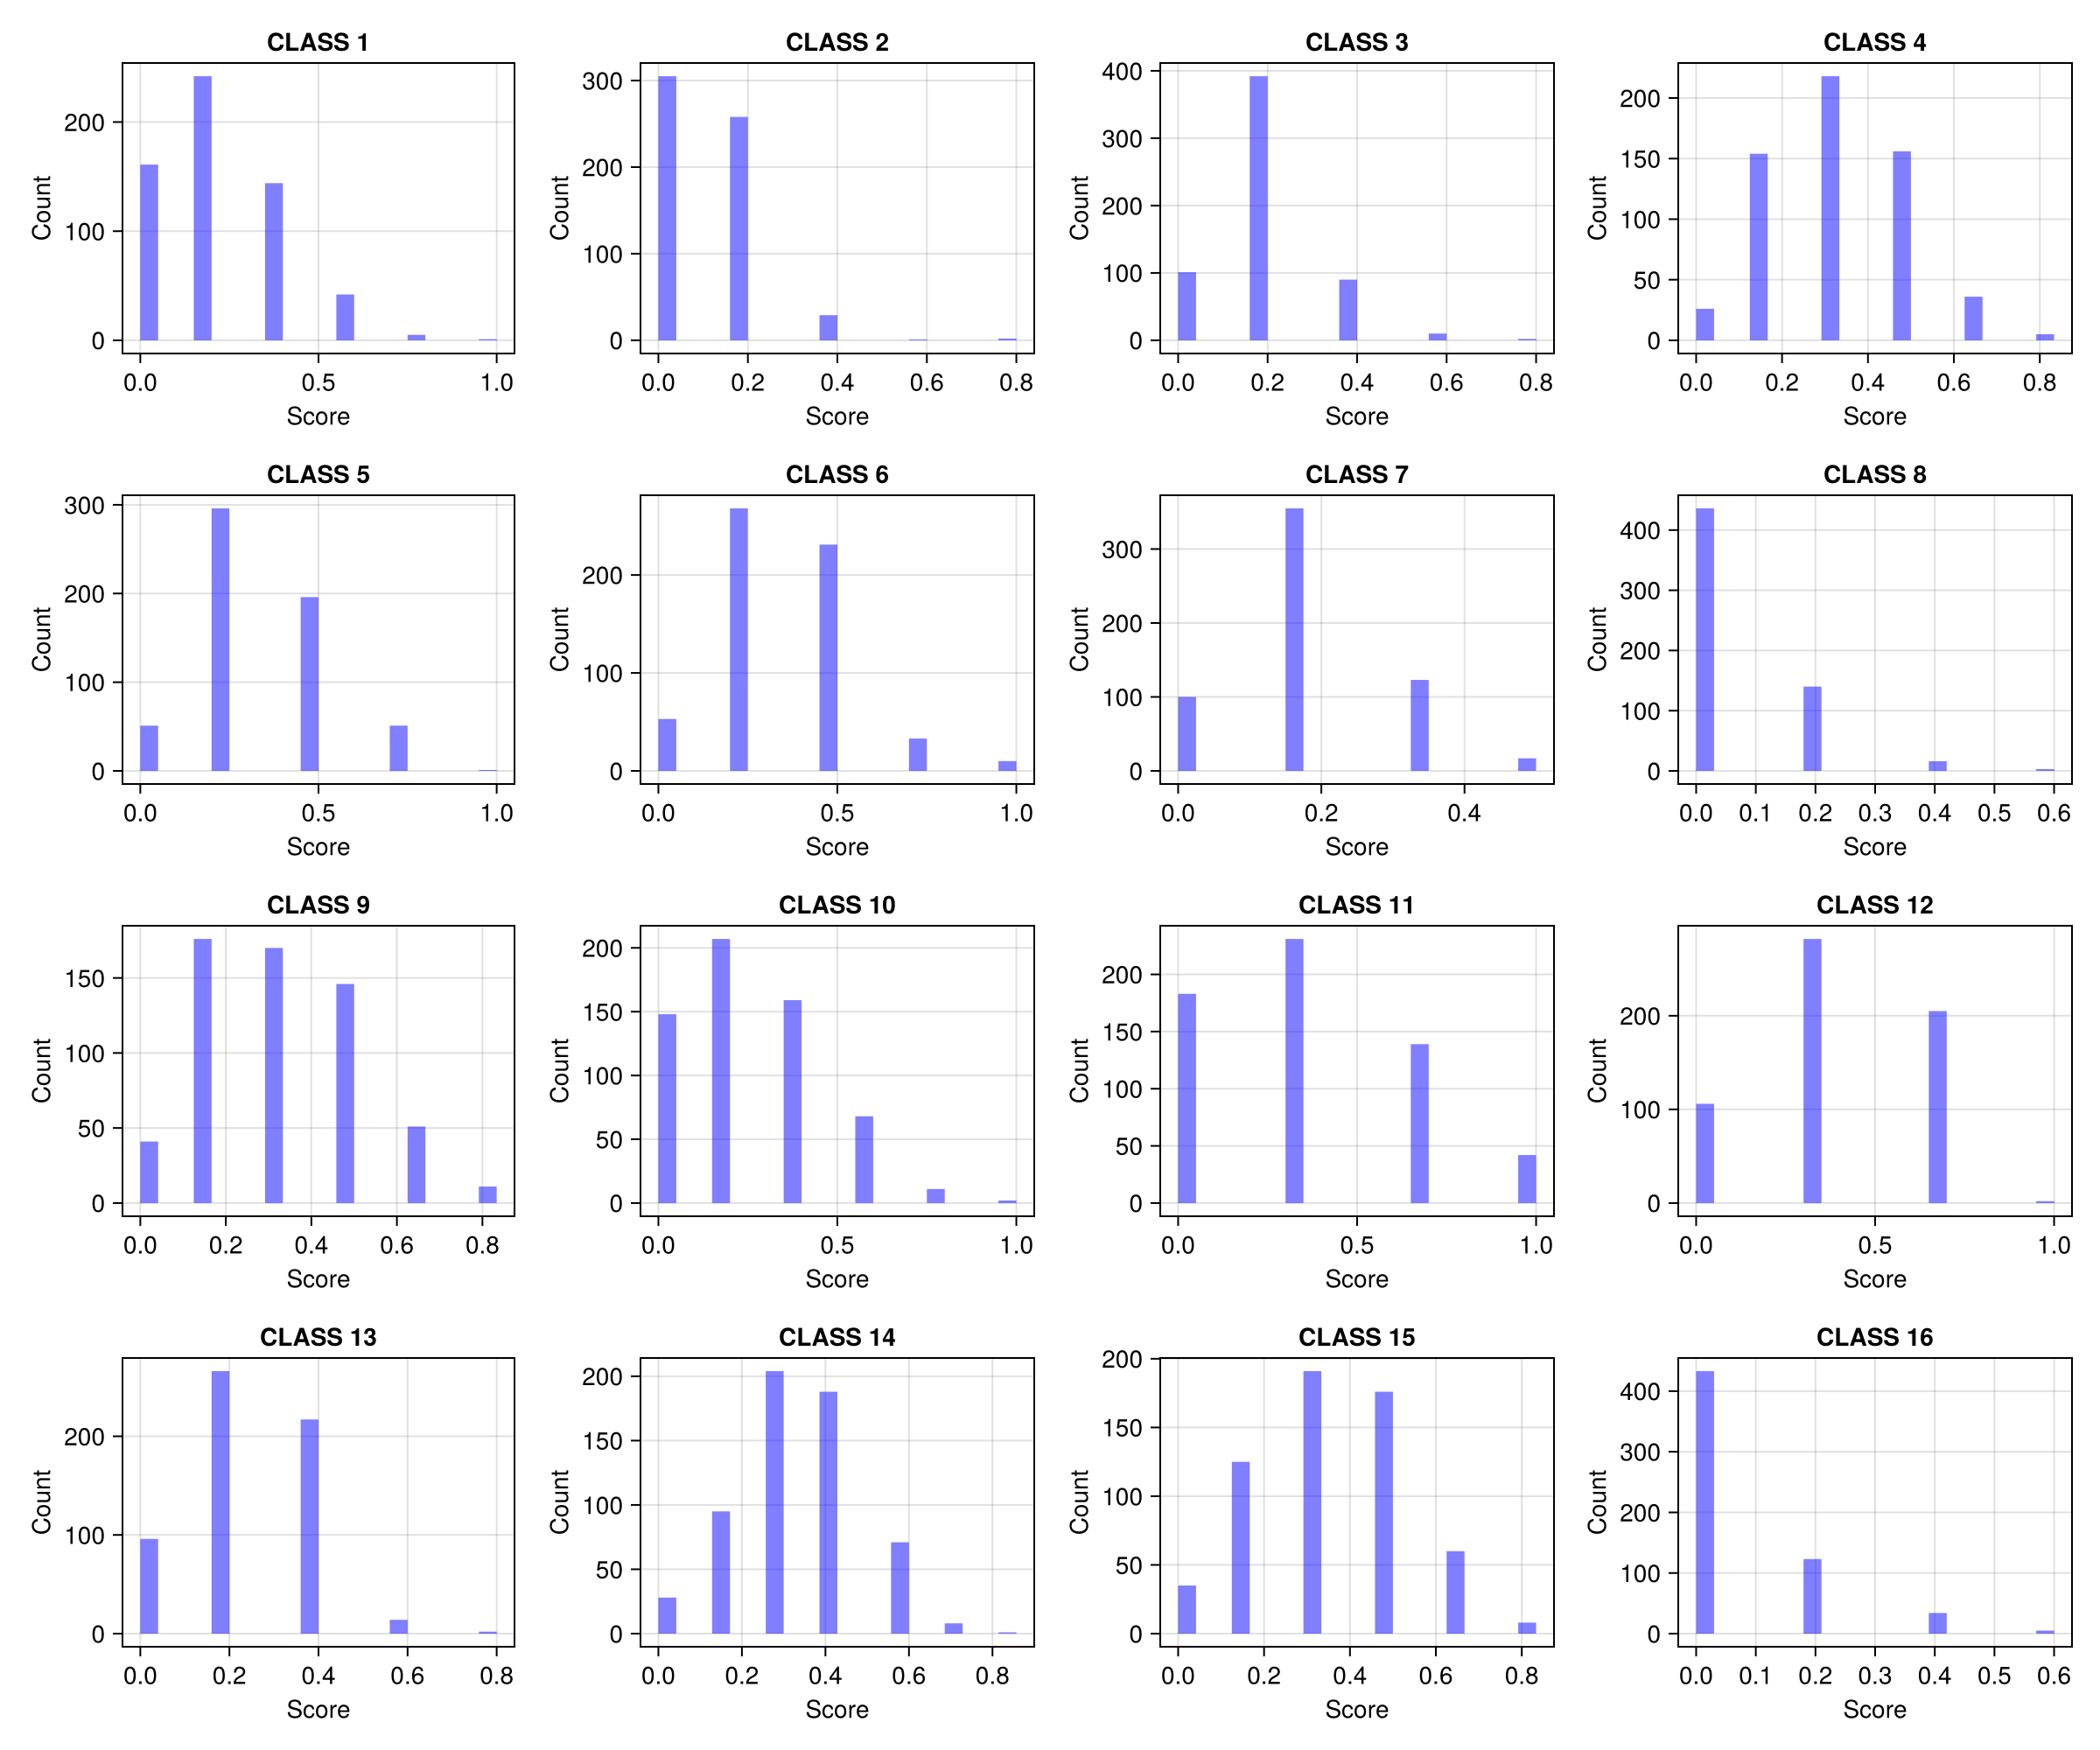

In [17]:
# Or flatten into a single vector of all elements
all_elements_union = vcat([value.elements for value in values(union_tot)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_union)
plot_histograms(peptides_full)

In [ ]:
# Or flatten into a single vector of all elements
all_elements_Gogl = vcat([value.elements for value in values(data_Gogl)]...)
file_content = read("/home/jboccato/Projects/bind_RBM/artifacts/peptides/peptides.txt", String)

peptides_full = score_strings(file_content, all_elements_Gogl)
plot_histograms(peptides_full)